# UDS emulator 

## Preliminaries

In [1]:
from my_imports import *

In [2]:
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
training_simulations_path   = yaml_data['training_simulations_path']
validation_simulations_path = yaml_data['validation_simulations_path']

inp_path =  yaml_data['inp_path']

## Create simulation objects from data

In [3]:
list_of_training_simulations    = os.listdir(training_simulations_path)
list_of_validation_simulations  = os.listdir(validation_simulations_path)

print('Number of training simulations: ', len(list_of_training_simulations))
print('Number of validation simulations: ', len(list_of_validation_simulations))


Number of training simulations:  163
Number of validation simulations:  29


In [4]:
num_events = 5

validation_simulations = utils.extract_simulations_from_folders(validation_simulations_path, inp_path, max_events =num_events)

validation_windows = []
events_to_validate= list(range(num_events))
for event in events_to_validate:
    sim = validation_simulations[event]
    validation_windows += sim.get_all_windows(steps_ahead = 1)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'


In [5]:
num_events = 5
training_simulations = utils.extract_simulations_from_folders(training_simulations_path, inp_path, max_events = num_events)

training_windows = []
events_to_train= list(range(num_events))
for event in events_to_train:
    sim = training_simulations[event]
    training_windows += sim.get_all_windows(steps_ahead = 1)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'


## Normalizer

In [10]:
normalizer = Normalizer(training_windows)

In [11]:
normalized_training_windows = normalizer.get_list_normalized_training_windows()
training_loader = DataLoader(normalized_training_windows, batch_size=32, shuffle = True)

In [12]:
normalized_validation_windows = [normalizer.normalize_window(val_win) for val_win in validation_windows]
validation_loader = DataLoader(normalized_validation_windows, batch_size=32)

## Training GNN

In [13]:
gnn_model = GNNModel()
optimizer = optim.Adam(gnn_model.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn = nn.MSELoss()

In [14]:
history = train(
    model = gnn_model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_fn = loss_fn,
    train_dl = training_loader,
    val_dl = validation_loader,
    epochs = 40,
    device = 'cpu',
    report_freq = 2
    )

train() called:model=GNNModel, opt=Adam(lr=0.001000), epochs=40,device=cpu

Epoch   1/ 40, train loss:  2.71, val loss:  0.19
Epoch   2/ 40, train loss:  0.28, val loss:  0.19
Epoch   4/ 40, train loss:  0.28, val loss:  0.19
Early stopping! The Current Loss: 0.18925801472253526

Time total:     78.85 sec
Time per epoch:  1.97 sec


## Results

In [15]:
viz.plot_loss(history)

## Using the metamodel

In [16]:
val_event =  validation_simulations[0]

length = val_event.simulation_length
entire_simulation_in_windows = val_event.get_all_windows(length-2)

In [17]:
sim_in_window=entire_simulation_in_windows[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

In [18]:
predicted_heads_tensor = normalizer.unnormalize_heads(gnn_model(sim_in_window))

In [19]:
predicted_heads_np = predicted_heads_tensor.detach().numpy()

In [20]:
name_nodes = norm_sim_in_window.name_nodes

In [21]:
predicted_heads_pd = pd.DataFrame(dict(zip(name_nodes, predicted_heads_np)))

In [22]:
swmm_heads_tensor = normalizer.unnormalize_heads(sim_in_window['y'])

In [23]:
swmm_heads_np = swmm_heads_tensor.numpy()

In [24]:
swmm_heads_pd = pd.DataFrame(dict(zip(name_nodes, swmm_heads_np)))

<AxesSubplot:>

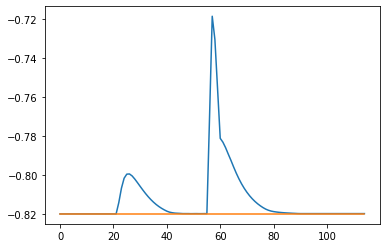

In [29]:
node = name_nodes[24]

swmm_heads_pd[node].plot()
predicted_heads_pd[node].plot()




# Scratchpad